## Estudo de caso: Comparação entre vetorização de textos utilizando transferlearning DistilBERT e CountVectorizer/Tfid


Grupo:

André Gomes Monteiro      RM: 89168

Leonardo Aranha           RM: 86919

Luara Maria Marino        RM: 89375

Renato Kenji Yamashiro    RM: 88847


Para a transformação dos textos será necessário a utilização da GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 21:02:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Imports necessários para a realização das predições

In [ ]:
#Manuseamento de gráficos e tabelas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

#Transformação do dataset para tipo Pyarrow
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

#Tokenização e vetorização dos textos utilizando transformer
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
from transformers import AutoModel
# Predições
import torch
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

import os
# Realização do modelo utilizando CountVectorizer e Tfid
import string ## String
from nltk.corpus import stopwords ## nltk stopwords
from sklearn.model_selection import train_test_split ## train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from imblearn.pipeline import Pipeline ## imblearn pipeline
from sklearn import preprocessing

In [4]:
url = 'https://raw.githubusercontent.com/prof-renato/data/main/humor_detection.csv'
df = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [90]:
df.head()

,text,humor,humor2
0,When is the best time to play racquet sports? ...,True,1
1,City apartments vs. suburban living: which one...,False,0
2,San francisco approves health warnings on ads ...,False,0
3,"How white privilege, white supremacy and insti...",False,0
4,The oil lobby has a pretty predictable respons...,False,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195000 entries, 0 to 194999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    194010 non-null  object
 1   humor   194000 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


## Feature Engineering

Temos abaixo o grpafico de barras contantdo o número de labels false e true, como não tem desbalanceamento da disttribuição, não será necessário a utilização do SMOTE.

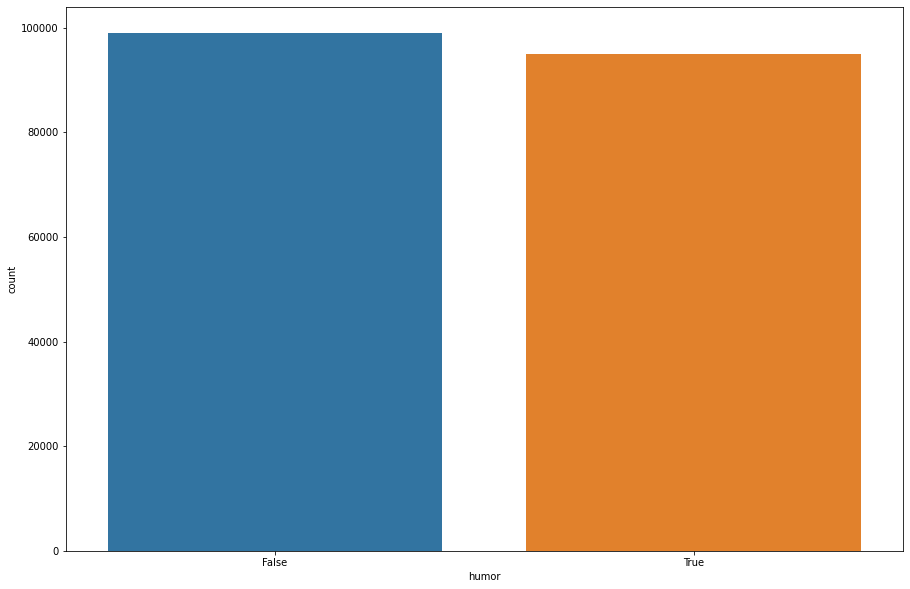

In [8]:
fig = plt.figure(figsize = (15, 10)) #criar gráfico de distribuição de variáveis resposta
sns.countplot(x='humor', data=df)

O gráfico abaixo mostra a distribuição dos quantidade de palavras que existem em cada label, observa-se que a mediana do label false fica em torno de 65 enquanto a de true fica na faixa de 70. Apesar dos quartis do true serem mais afastados em relação a sua mediana, o seu desvio é menor que a false.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0.98, '')

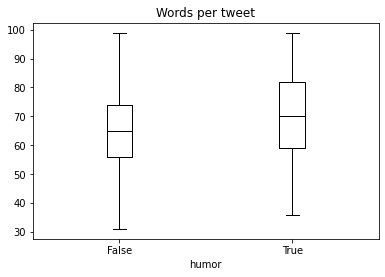

In [9]:
df['Words per tweet'] = df['text'].str.len()
df.boxplot("Words per tweet", by="humor", grid=False, showfliers=False, color="black")
plt.suptitle("")

In [11]:
df = df[['text', 'humor']]

In [12]:
df = df.dropna()

In [13]:
df

,text,humor
0,When is the best time to play racquet sports? ...,True
1,City apartments vs. suburban living: which one...,False
2,San francisco approves health warnings on ads ...,False
3,"How white privilege, white supremacy and insti...",False
4,The oil lobby has a pretty predictable respons...,False
...,...,...
194995,What did pinocchio say to his girlfriend sit o...,True
194996,Soccer player mistaken for terrorist in belgia...,False
194997,Airbnb slapped with suit for alleged discrimin...,False
194998,Report: murdoch daughter splits from 'ultimate...,False


## Realização da vetorização utilizando Transformer

In [15]:
df_train = df.sample(frac = 0.7)
df_test = df.drop(df_train.index)

In [91]:
df_train.head()

,text,humor
50699,Happy valentines day. and merry christmas to f...,True
78783,This is how to win at parenting and life,False
131359,My friend and i are in a beard growing contest...,True
113859,"What makes a little bit of sense, but you'll n...",True
96877,Why this woman who cast an illegal vote for do...,False


In [92]:
df_test.head()

,text,humor
0,When is the best time to play racquet sports? ...,True
3,"How white privilege, white supremacy and insti...",False
4,The oil lobby has a pretty predictable respons...,False
9,Regular naps prevent aging... especially if yo...,True
10,Hero firefighter slides onto thin ice to rescu...,False


In [18]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
dataset_train = ds.dataset(pa.Table.from_pandas(df_train ).to_batches())
dataset_test = ds.dataset(pa.Table.from_pandas(df_test ).to_batches())
### convert to Huggingface dataset
hg_train = Dataset(pa.Table.from_pandas(df_train ))
hg_test = Dataset(pa.Table.from_pandas(df_test ))

In [89]:
type(dataset_train)

pyarrow._dataset.InMemoryDataset

In [20]:
hg_train 

Dataset({
    features: ['text', 'humor', '__index_level_0__'],
    num_rows: 135107
})

In [21]:
hg_test

Dataset({
    features: ['text', 'humor', '__index_level_0__'],
    num_rows: 57903
})

In [22]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:


distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [25]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [26]:
train_ds_encoded =  hg_train.map(tokenize, batched=True, batch_size=None)
test_ds_encoded =  hg_test.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
print(tokenize(hg_train[:2]))

{'input_ids': [[101, 3407, 10113, 2015, 2154, 1012, 1998, 12831, 4234, 2000, 3027, 2094, 1010, 25812, 1998, 23564, 4244, 1012, 102], [101, 2023, 2003, 2129, 2000, 2663, 2012, 28586, 1998, 2166, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [28]:
print(train_ds_encoded )

Dataset({
    features: ['text', 'humor', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 135107
})


In [30]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
             if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [32]:
train_ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "humor"])
test_ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "humor"])

In [33]:
train_ds_hidden = train_ds_encoded.map(extract_hidden_states, batched=True)
test_ds_hidden = test_ds_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/136 [00:00<?, ?ba/s]

  0%|          | 0/58 [00:00<?, ?ba/s]

In [34]:
test_ds_hidden 

Dataset({
    features: ['text', 'humor', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 57903
})

In [36]:
X_train = np.array(train_ds_hidden["hidden_state"])
X_test = np.array(test_ds_hidden["hidden_state"])
y_train = np.array(train_ds_hidden["humor"])
y_test = np.array(test_ds_hidden["humor"])

In [37]:
X_train

array([[-0.06870525, -0.27309737,  0.32429245, ...,  0.09306891,
         0.54789954,  0.1878194 ],
       [-0.15322377, -0.0731682 ,  0.02640932, ..., -0.20386767,
         0.24862753,  0.3728054 ],
       [ 0.17879266, -0.10061164,  0.200921  , ..., -0.11488373,
         0.3783071 ,  0.32037196],
       ...,
       [-0.08749916,  0.11912765, -0.01280441, ..., -0.04939692,
         0.46133444,  0.48651117],
       [-0.34470233,  0.00205349,  0.06580486, ..., -0.10897338,
         0.40565607,  0.238829  ],
       [ 0.1725966 , -0.08024255, -0.13581797, ..., -0.13204488,
         0.54404896,  0.33915284]], dtype=float32)

## Realização da redução de dimensionalidade do dataset para geração do gráfico de ilhas de calor.

O UMAP é um algoritmo de redução de dimensionalidade não linear, onde é possível a visualização em 2D, onde a metrica foi o cosine correlation, na qual é analisado a distância angular entre os vetores.

In [38]:
!pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [43]:
reducer = umap.UMAP()

In [44]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["humor"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,humor
0,6.477317,3.590206,True
1,8.408931,4.471020,False
2,8.610800,11.149849,True
3,8.696876,7.361522,True
4,9.652520,3.643743,False


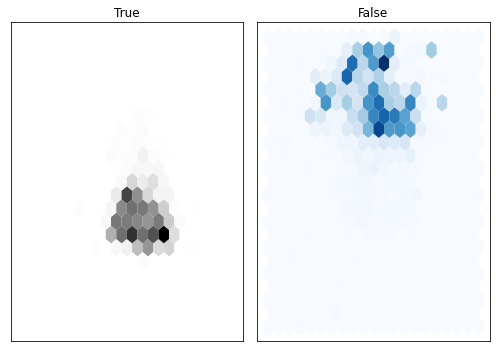

In [47]:
fig, axes = plt.subplots(1,2 , figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys","Blues"]
labels = df['humor'].unique() 

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"humor== {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Realização da regressão logítisca com 3000 épocas.

In [48]:

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)


LogisticRegression(max_iter=3000)

In [49]:
X_train

array([[-0.06870525, -0.27309737,  0.32429245, ...,  0.09306891,
         0.54789954,  0.1878194 ],
       [-0.15322377, -0.0731682 ,  0.02640932, ..., -0.20386767,
         0.24862753,  0.3728054 ],
       [ 0.17879266, -0.10061164,  0.200921  , ..., -0.11488373,
         0.3783071 ,  0.32037196],
       ...,
       [-0.08749916,  0.11912765, -0.01280441, ..., -0.04939692,
         0.46133444,  0.48651117],
       [-0.34470233,  0.00205349,  0.06580486, ..., -0.10897338,
         0.40565607,  0.238829  ],
       [ 0.1725966 , -0.08024255, -0.13581797, ..., -0.13204488,
         0.54404896,  0.33915284]], dtype=float32)

In [50]:
lr_clf.score(X_test, y_test)

0.969932473274269

In [53]:

y_preds = lr_clf.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print('\n')
print(classification_report(y_test, y_preds))

[[28602   904]
 [  837 27560]]


              precision    recall  f1-score   support

       False       0.97      0.97      0.97     29506
        True       0.97      0.97      0.97     28397

    accuracy                           0.97     57903
   macro avg       0.97      0.97      0.97     57903
weighted avg       0.97      0.97      0.97     57903



## Resultados utilizando Transformer

A acurácia foi de 97% nas predições de teste.

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193010 entries, 0 to 194999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    193010 non-null  object
 1   humor   193010 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


## Realização da prediçã utilizando CountVectorizer e Tfid

Por realizar regressão logística, será transformado a coluna humor em valores numéricos.

In [80]:

le = preprocessing.LabelEncoder()

for col in df.columns[df.dtypes == object]:
  df['humor2'] = le.fit_transform(df['humor'].astype(str))

In [69]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

text_process(df['text'].iloc[1])


['City', 'apartments', 'vs', 'suburban', 'living', 'one', 'wins']

In [ ]:
df

In [83]:

X = df['text']
y = df['humor2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) #dividindo em conjuntos de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135107,), (57903,), (135107,), (57903,))

In [ ]:
X_train

In [84]:
y_train

68271     0
175381    1
126680    0
93627     0
9633      1
         ..
121146    1
104799    1
133327    0
148399    1
123248    0
Name: humor2, Length: 135107, dtype: int64

In [85]:
model = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', lr_clf),  # logistic regression
])

In [86]:
model.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f46ab943320>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression(max_iter=3000))])

In [87]:
y_pred =  model.predict(X_test)

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     29349
           1       0.91      0.90      0.91     28554

    accuracy                           0.91     57903
   macro avg       0.91      0.91      0.91     57903
weighted avg       0.91      0.91      0.91     57903



## Resuldados utililizando CountVectorizer e Tfid

A acurácia foi de 91%.